# Suit Classification





## Introduction
The [Cards Image Dataset](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/data) is a comprehensive collection of playing card images designed for classification tasks. It encompasses 53 distinct classes, representing each card in a standard deck plus a joker. The dataset is organized into training, validation, and test sets, with images standardized to 224x224 pixels.

### Download Dataset

In [21]:
!curl -L -o cards-image-datasetclassification.zip\
  https://www.kaggle.com/api/v1/datasets/download/gpiosenka/cards-image-datasetclassification

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  385M  100  385M    0     0   205M      0  0:00:01  0:00:01 --:--:--  270M


In [4]:
!unzip cards-image-datasetclassification.zip

Archive:  cards-image-datasetclassification.zip
replace 14card types-14-(200 X 200)-94.61.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Import Libraries

In [6]:
import os
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import time

### Device

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Dataset & DataLoader
Create a dataset with four classes [spades, clubs, hearts, diamonds].
(ignore joker)

In [8]:
# Define a custom dataset class
class SuitsDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.transform = transform
        
        self.classes = ['hearts', 'spades', 'diamonds', 'clubs']
        self.class_to_idx = {suit: idx for idx, suit in enumerate(self.classes)}

        self.image_paths = []
        self.labels = []


        for subdir, _, files in os.walk(root_dir):
            folder = os.path.basename(subdir)
            for suit in self.classes:
                if suit in folder:
                    for fname in files:
                        self.image_paths.append(os.path.join(subdir, fname))
                        self.labels.append(self.class_to_idx[suit])
                    break

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_sample_from_class(self, label):
        for idx in np.random.permutation(len(self)):
            if self[idx][1] == label:
                return self[idx][0]

    def get_unNormalize(self, image, mean, std):
        """
        image: a torch.Tensor of shape (C, H, W), already normalized
        mean, std: sequences of length C
        Returns a NumPy array of shape (H, W, C) in [0, 1].
        """
        # 1) clone and move to CPU so we don’t mutate the original
        img = image.clone().cpu()
        # 2) un-normalize each channel
        for c, (m, s) in enumerate(zip(mean, std)):
            img[c] = img[c] * s + m
        # 3) convert to H×W×C NumPy and clip to [0,1]
        np_img = img.numpy().transpose(1, 2, 0)
        return np.clip(np_img, 0, 1)



In [9]:
# Create Train, Validataion and Test set
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomRotation(10, expand=True, fill=(0,0,0)),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}


train_dataset = SuitsDataset(
    root_dir="/kaggle/working/train",
    transform=image_transforms['train']
)

val_dataset = SuitsDataset(
    root_dir="/kaggle/working/valid",
    transform=image_transforms['valid']
)
test_dataset = SuitsDataset(
    root_dir="/kaggle/working/test",
    transform=image_transforms['test']
)

In [10]:
print("train dataset size:", len(train_dataset))
print("valid dataset size:", len(val_dataset))
print("test  dataset size:", len(test_dataset))

train dataset size: 7509
valid dataset size: 260
test  dataset size: 260


In [11]:
# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=0)

### Visualization
Visualize 5 random images from each class using `plt.subplots`

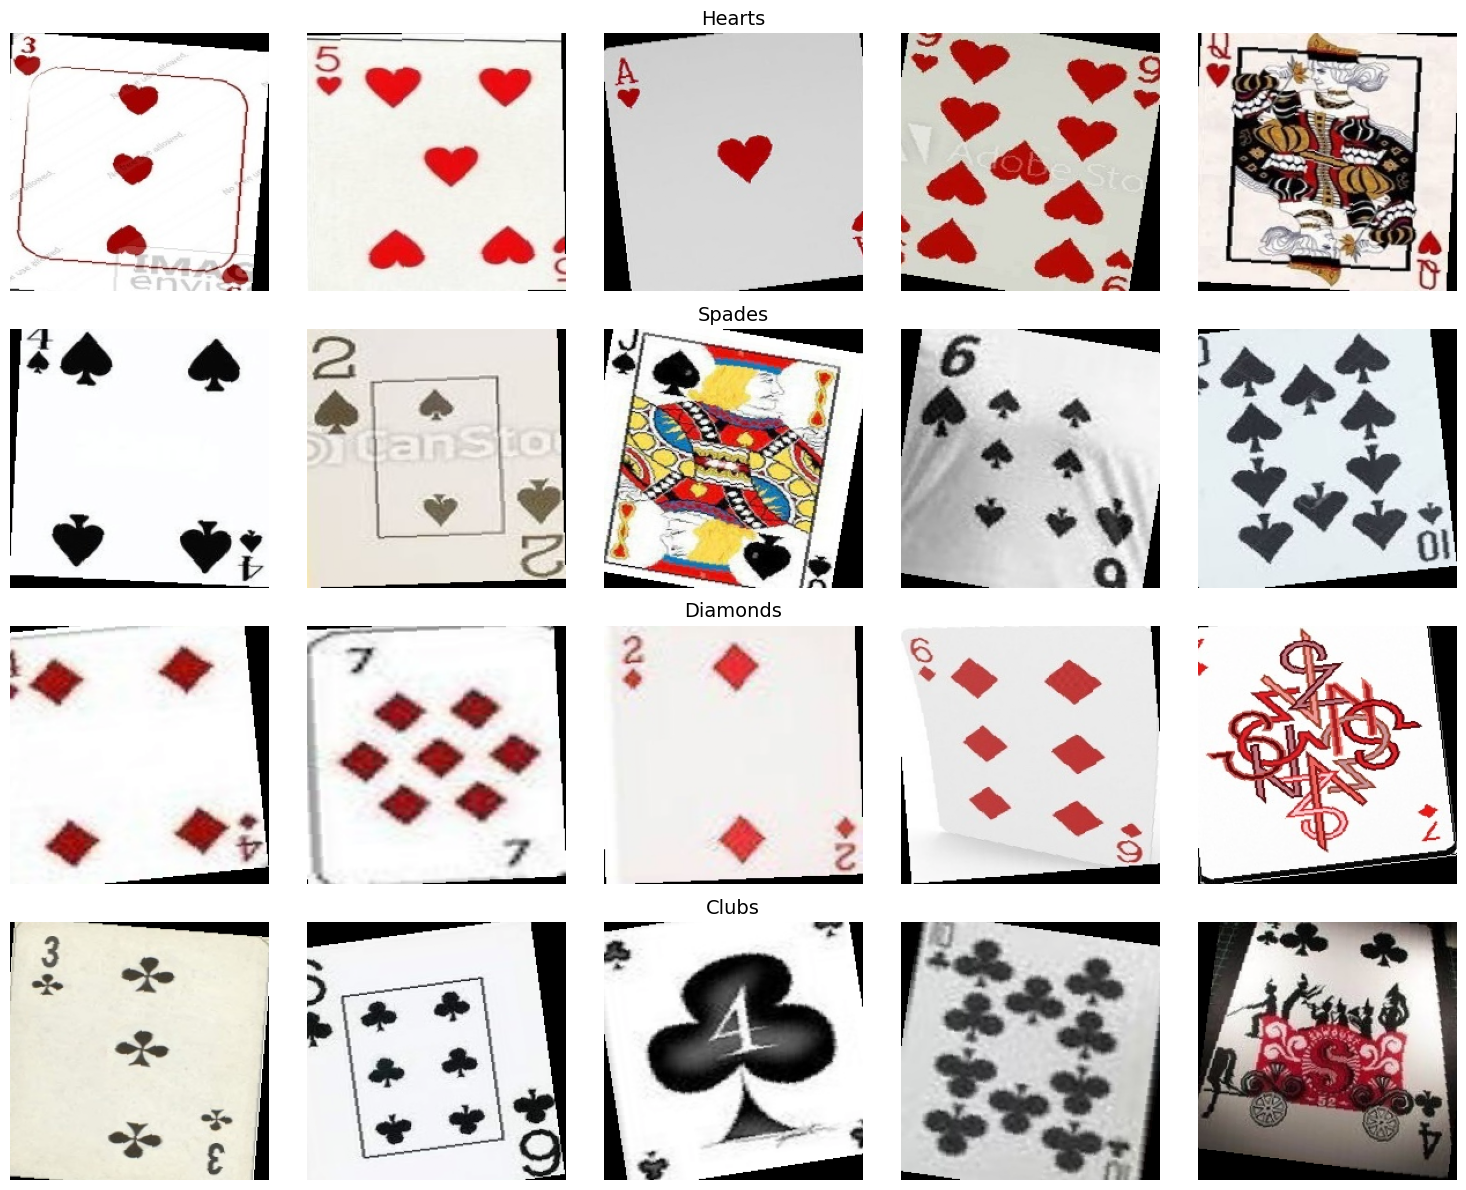

In [15]:
classes = train_dataset.classes

num_cols = 5
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, 
                         figsize=(num_cols * 3, num_rows * 3),
                         squeeze=False)

for row, suit in enumerate(train_dataset.classes):
    label = train_dataset.class_to_idx[suit]
    for col in range(num_cols):

        img = train_dataset.get_sample_from_class(label)
        img = train_dataset.get_unNormalize(img, mean, std)
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        
        if col == num_cols // 2:
            axes[row, col].set_title(suit.capitalize(), fontsize=14)

plt.tight_layout()
plt.show()
    

## Model

In [16]:
# load a Pre-trained alexnet and move it to device
model = torchvision.models.alexnet(pretrained=True)
model = model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Train

### Criterion, Optimizer and Scheduler

In [17]:
# Freeze model parameters
# we only want the classifier layers and the last feature layer to update
for param in model.parameters():
    param.requires_grad = False

num_classes = 4 

model.classifier[6] = nn.Linear(4096, num_classes)

for idx in (10, ):
    for param in model.features[idx].parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
# Define Optimizer and Loss criterion
criterion = nn.CrossEntropyLoss()

trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(
    trainable_params,
    lr=5e-5,
    weight_decay=1e-4  
)

optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0.0001
)

### Fine-tune the model

In [22]:
def train_and_validate(model, criterion, optimizer, num_epochs=10):

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients 
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            # print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        # Validation
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)

                # update the valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)

                # print(("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item())))

        # find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataset)
        avg_train_acc = train_acc / len(train_dataset)

        # find average validation loss and accuracy
        avg_valid_loss = valid_loss / len(val_dataset)
        avg_valid_acc = valid_acc / len(val_dataset)

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))


        # Save if the model has best accuracy till now
        # torch.save(model, dataset+'_model_'+str(epoch)+'.pt')

    return model, history            

In [23]:
model = model.to(device)

trained_model, history = train_and_validate(model, criterion, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10


 10%|█         | 1/10 [00:18<02:42, 18.08s/it]

Epoch : 001, Training: Loss: 0.1060, Accuracy: 96.0847%, 
		Validation : Loss : 0.2398, Accuracy: 91.5385%, Time: 18.0827s
Epoch: 2/10


 20%|██        | 2/10 [00:36<02:28, 18.51s/it]

Epoch : 002, Training: Loss: 0.0964, Accuracy: 96.1779%, 
		Validation : Loss : 0.2149, Accuracy: 93.0769%, Time: 18.8052s
Epoch: 3/10


 30%|███       | 3/10 [00:54<02:06, 18.14s/it]

Epoch : 003, Training: Loss: 0.0817, Accuracy: 97.1634%, 
		Validation : Loss : 0.2353, Accuracy: 92.6923%, Time: 17.6995s
Epoch: 4/10


 40%|████      | 4/10 [01:13<01:49, 18.31s/it]

Epoch : 004, Training: Loss: 0.0752, Accuracy: 97.2034%, 
		Validation : Loss : 0.2170, Accuracy: 93.4615%, Time: 18.5625s
Epoch: 5/10


 50%|█████     | 5/10 [01:31<01:32, 18.48s/it]

Epoch : 005, Training: Loss: 0.0724, Accuracy: 97.4830%, 
		Validation : Loss : 0.2551, Accuracy: 93.0769%, Time: 18.7813s
Epoch: 6/10


 60%|██████    | 6/10 [01:50<01:13, 18.35s/it]

Epoch : 006, Training: Loss: 0.0678, Accuracy: 97.6029%, 
		Validation : Loss : 0.1956, Accuracy: 94.6154%, Time: 18.0882s
Epoch: 7/10


 70%|███████   | 7/10 [02:08<00:55, 18.49s/it]

Epoch : 007, Training: Loss: 0.0694, Accuracy: 97.6828%, 
		Validation : Loss : 0.2326, Accuracy: 92.6923%, Time: 18.7876s
Epoch: 8/10


 80%|████████  | 8/10 [02:26<00:36, 18.33s/it]

Epoch : 008, Training: Loss: 0.0571, Accuracy: 97.9358%, 
		Validation : Loss : 0.2058, Accuracy: 94.6154%, Time: 17.9819s
Epoch: 9/10


 90%|█████████ | 9/10 [02:45<00:18, 18.43s/it]

Epoch : 009, Training: Loss: 0.0586, Accuracy: 97.8293%, 
		Validation : Loss : 0.2214, Accuracy: 92.6923%, Time: 18.6598s
Epoch: 10/10


100%|██████████| 10/10 [03:03<00:00, 18.38s/it]

Epoch : 010, Training: Loss: 0.0555, Accuracy: 98.0423%, 
		Validation : Loss : 0.2655, Accuracy: 91.5385%, Time: 18.3482s


### Visualize loss & Accuracy

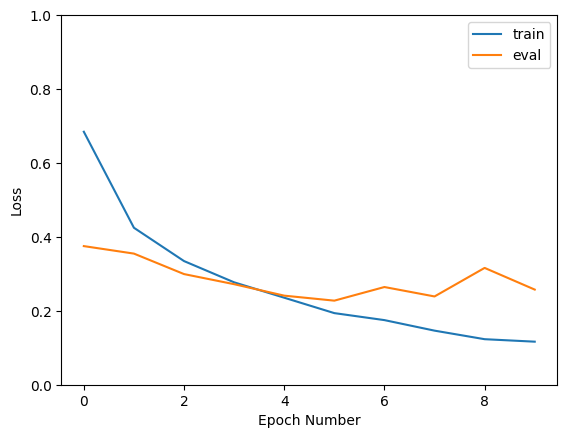

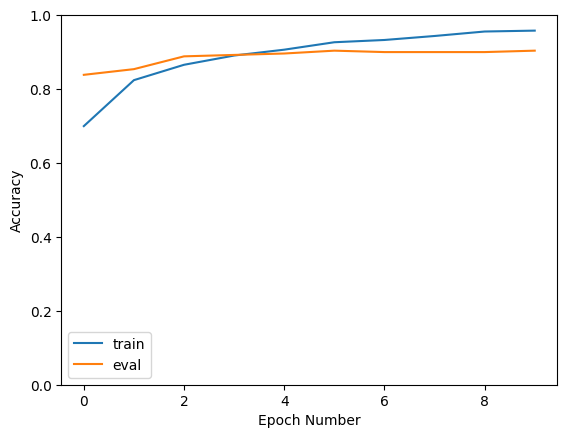

In [142]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['train', 'eval'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

plt.plot(history[:,2:4])
plt.legend(['train', 'eval'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [24]:
model.eval()
test_loss = 0.0
correct   = 0
total     = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        outputs = model(inputs)
        loss    = criterion(outputs, labels)

        # accumulate loss
        test_loss += loss.item() * labels.size(0)

        # accumulate accuracy
        preds     = outputs.argmax(dim=1)
        correct  += (preds == labels).sum().item()
        total    += labels.size(0)

# 4) Compute averages
avg_test_loss = test_loss / total
test_acc      = correct / total * 100

# 5) Print results
print(f"Test Loss: {avg_test_loss:.4f}  |  Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.2030  |  Test Accuracy: 93.08%


In [25]:
correct_imgs, correct_labels, correct_preds = [], [], []
wrong_imgs,   wrong_labels,   wrong_preds   = [], [], []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds   = outputs.argmax(dim=1)

        for img, true_lbl, pred_lbl in zip(inputs, labels, preds):
            img_cpu = img.cpu()
            t = true_lbl.cpu().item()
            p = pred_lbl.cpu().item()

            if p == t:
                correct_imgs.append(img_cpu)
                correct_labels.append(t)
                correct_preds.append(p)
            else:
                wrong_imgs.append(img_cpu)
                wrong_labels.append(t)
                wrong_preds.append(p)


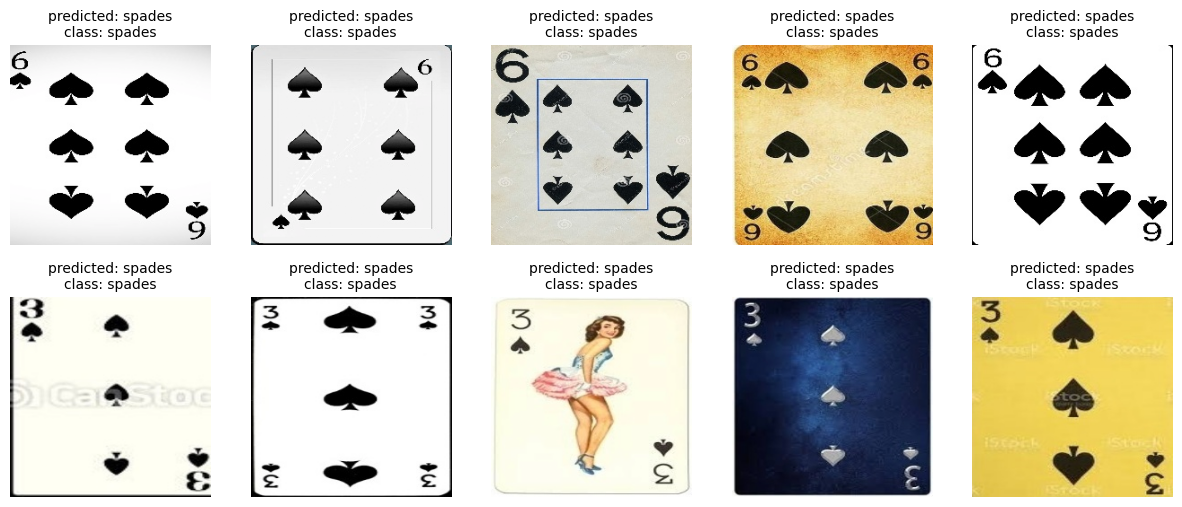

In [26]:
num_to_show = 10
rows, cols = 2, 5

# create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for idx, ax in enumerate(axes.flatten()):

    img = test_dataset.get_unNormalize(correct_imgs[idx], mean, std)

    true_name = test_dataset.classes[correct_labels[idx]]
    pred_name = test_dataset.classes[correct_preds[idx]]

    ax.imshow(img)
    ax.set_title(f"predicted: {pred_name}\nclass: {true_name}", fontsize=10)
    ax.axis('off')

plt.show()

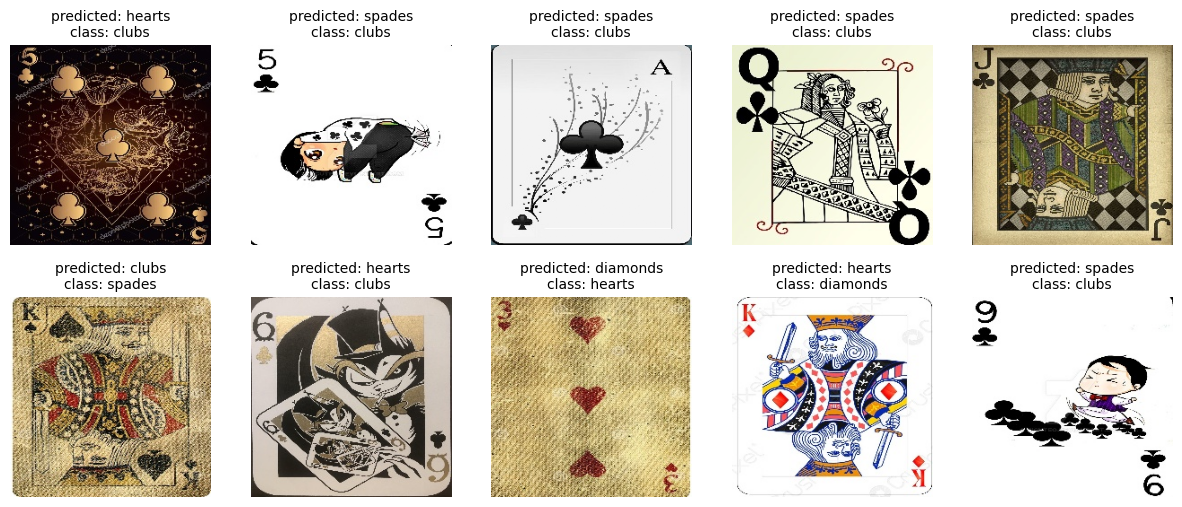

In [188]:
num_to_show = 10
rows, cols = 2, 5

# create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for idx, ax in enumerate(axes.flatten()):

    img = test_dataset.get_unNormalize(wrong_imgs[idx], mean, std)

    true_name = test_dataset.classes[wrong_labels[idx]]
    pred_name = test_dataset.classes[wrong_preds[idx]]

    ax.imshow(img)
    ax.set_title(f"predicted: {pred_name}\nclass: {true_name}", fontsize=10)
    ax.axis('off')

plt.show()

## Visualization of Filters

Visualize different channels of first conv

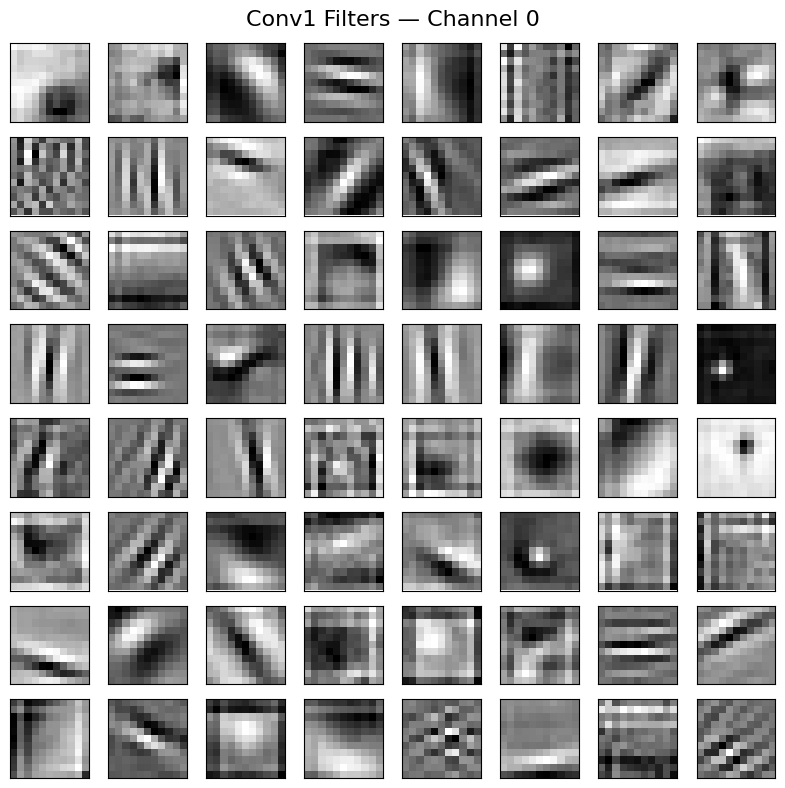

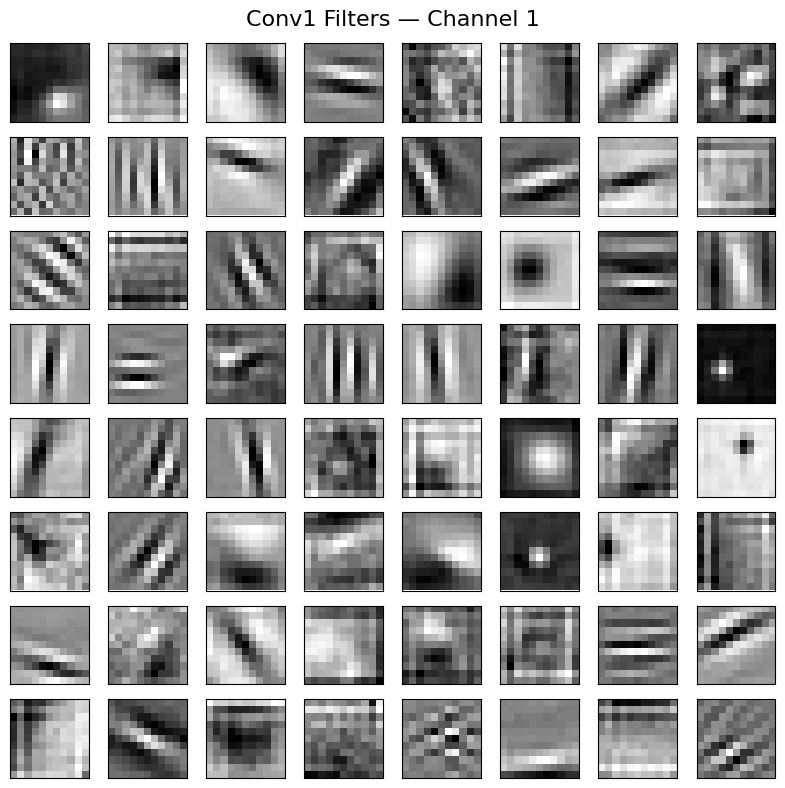

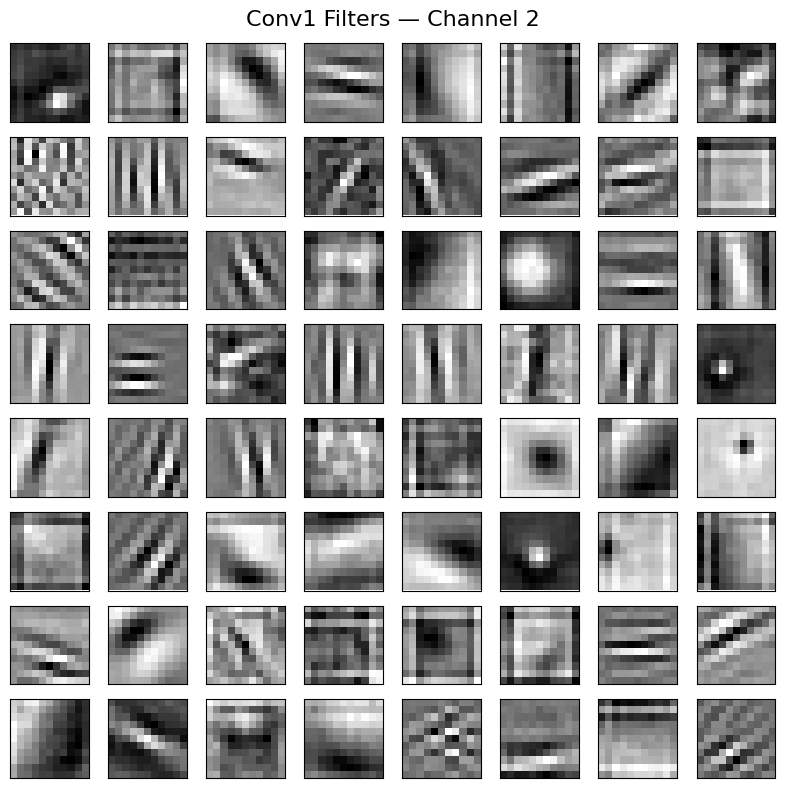

In [34]:
# it seems like channels have extraxted some meaningful features from input like sharp sides of the digit

w = model.features[0].weight.data.clone().cpu()


for c in range(w.shape[1]):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    fig.suptitle(f'Conv1 Filters — Channel {c}', fontsize=16)
    # loop over the 64 filters
    for i, ax in enumerate(axes.flat):
        if i < w.shape[0]:
            kernel = w[i, c, :, :]
            kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
            ax.imshow(kernel.numpy(), cmap='gray', vmin=0, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()


Extract and visualize feature maps from the first, second, and third convolutional layers.

we first need to select an image from the test set

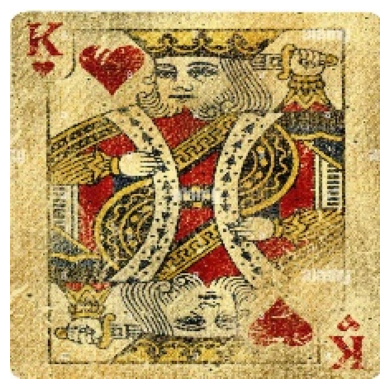

In [36]:
image = test_dataset.get_sample_from_class(np.random.randint(4))
plt.imshow(test_dataset.get_unNormalize(image, mean, std))
          
plt.axis("off")
plt.show()

Clip the ResNet model at three different points (first, second, and third convolutional layers)

In [37]:
alexnet = torchvision.models.alexnet(pretrained=True)

clipped_model1 = nn.Sequential(*alexnet.features[:3])
clipped_model2 = nn.Sequential(*alexnet.features[:6])
clipped_model3 = nn.Sequential(*alexnet.features[:8])

print(clipped_model1)
print(clipped_model2)
print(clipped_model3)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride

In [ ]:
# no explanation was in the notebook!!!